In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'bearing-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F657721%2F1161622%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240413%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240413T142838Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D0233d120c8b9646b96fb5d97a58688e60c83dc5d0955c3de4d03d0d184c2cf66d2e1743aaff503fe3235eae5573534119552b83fdf7f694fb2f3bd1224d4c83314f462d0817f2787e4f61e69bd63b7b0b336c7d7c80f40974584ef4820769bf1d6c9e5357468ed0ebbf6dc090aca7fe095fcb13a37c563251c6f7c60fcb586486457c3e0808f4e646fc4b1304b67d4431352ce276a7d2d96733ea9a5d45b0bd4c9079b20fb2bec53148eed634bfceab5574f3bad0b8ae818f08d1167d9d3415cf1dad878b44d2785a35b6090a71845bde0742d9046616a2132319d636b84024e54120a48f28d2baa2adcf875e5521e9ff6948ec6d74c8f5d9247ab4fdfbced08'

KAGGLE_INPUT_PATH='content/kaggle/input'
KAGGLE_WORKING_PATH='content/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount content/kaggle/input/ 2> /dev/null
shutil.rmtree('content/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 1671101276 bytes downloaded
Downloaded and uncompressed: bearing-dataset
Data source import complete.


Reference: [Deep learning for TSC tutorial Youtube](https://www.youtube.com/watch?v=N4rdboHh6sg)

https://towardsdatascience.com/machine-learning-for-anomaly-detection-and-condition-monitoring-d4614e7de770


---

# Anomaly Detection

- PCA
- AutoEncoder


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import os
import pandas as pd
import numpy as np
from sklearn import preprocessing
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow

from numpy.random import seed
from keras.layers import Input, Dropout
from keras.layers import Dense
from keras.models import Model, Sequential, load_model
from keras import regularizers
from keras.models import model_from_json

import warnings
warnings.filterwarnings(action='ignore')

# Input data files are available in the read-only "../input/" directory

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
data_dir = 'content/kaggle/input/bearing-dataset/2nd_test/2nd_test'
merged_data = pd.DataFrame()

for filename in os.listdir(data_dir):
    dataset = pd.read_csv(os.path.join(data_dir, filename), sep='\t')
    dataset_mean_abs = np.array(dataset.abs().mean())
    dataset_mean_abs = pd.DataFrame(dataset_mean_abs.reshape(1, 4))
    dataset_mean_abs.index = [filename]
    merged_data = pd.concat([merged_data, dataset_mean_abs])

merged_data.columns = ['Bearing 1', 'Bearing 2', 'Bearing 3', 'Bearing 4']


In [ ]:
# transform index to datetime format
merged_data.index = pd.to_datetime(merged_data.index, format='%Y.%m.%d.%H.%M.%S')

merged_data = merged_data.sort_index()
merged_data.to_csv('merged_Dataset_BearingTest_2.csv')
merged_data.head()

,Bearing 1,Bearing 2,Bearing 3,Bearing 4
2004-02-12 10:32:39,0.058333,0.071832,0.083242,0.043067
2004-02-12 10:42:39,0.058995,0.074006,0.084435,0.044541
2004-02-12 10:52:39,0.060236,0.074227,0.083926,0.044443
2004-02-12 11:02:39,0.061455,0.073844,0.084457,0.045081
2004-02-12 11:12:39,0.061361,0.075609,0.082837,0.045118


<Axes: >

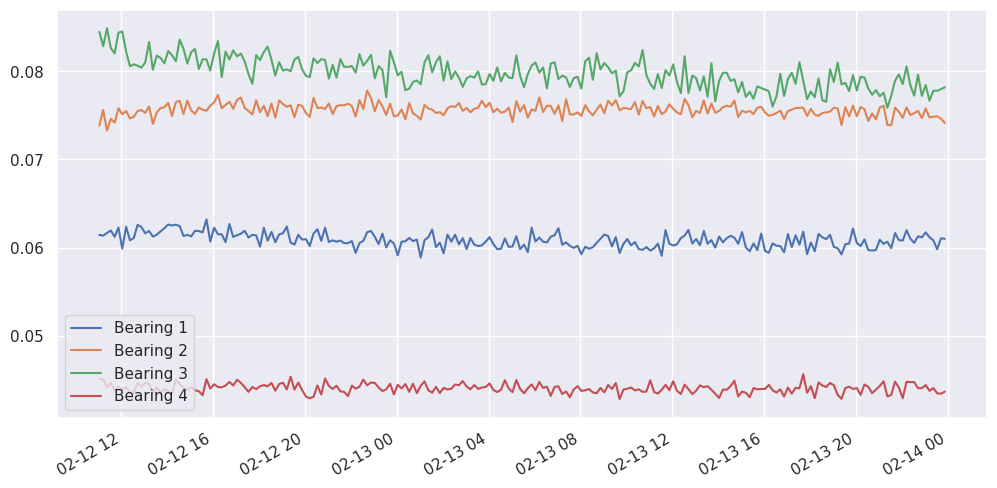

In [ ]:
# define train/test data
dataset_train = merged_data['2004-02-12 11:02:39':'2004-02-13 23:52:39']
dataset_test = merged_data['2004-02-13 23:52:39':]

dataset_train.plot(figsize = (12, 6))

In [ ]:
# Normalize data

scaler = preprocessing.MinMaxScaler()   # re-scale the data to be in the range [0, 1]

X_train = pd.DataFrame(scaler.fit_transform(dataset_train),
                       columns=dataset_train.columns,
                       index=dataset_train.index)

# Random shuffle training data
X_train.sample(frac=1)

X_test = pd.DataFrame(scaler.fit_transform(dataset_test),
                       columns=dataset_test.columns,
                       index=dataset_test.index)

### PCA type model for anomaly detection

차웜 감소(Dimensionality Reduction)

: 고차원 센서 데이터를 다루는 것은 종종 어렵기 때문에 변수의 수를 줄이기 위한 기술이 있다.

- PCA (Principal Component Analysis) 주성분 분석
    - info: https://kkokkilkon.tistory.com/169

In [ ]:
# sensor readings을 2개 main principal components로 압축

from sklearn.decomposition import PCA

pca = PCA(n_components=2, svd_solver='full')

X_train_PCA = pca.fit_transform(X_train)
X_train_PCA = pd.DataFrame(X_train_PCA)
X_train_PCA.index = X_train.index

X_test_PCA = pca.transform(X_test)
X_test_PCA = pd.DataFrame(X_test_PCA)
X_test_PCA.index = X_test.index

In [ ]:
# Mahalanobis distance metric: distance가 특정 입계값을 초과하는 경우 "anomaly"로 분류

def cov_matrix(data, verbose=False):
    covariance_matrix = np.cov(data, rowvar=False)
    if is_pos_def(covariance_matrix):
        inv_covariance_matrix = np.linalg.inv(covariance_matrix)
        if is_pos_def(inv_covariance_matrix):
            return covariance_matrix, inv_covariance_matrix
        else:
            print("Error: Inverse of Covariance Matrix is not positive definite!")
    else:
        print("Error: Covariance Matrix is not positive definite!")


def MahalanobisDist(inv_cov_matrix, mean_distr, data, verbose=False):
    inv_covariance_matrix = inv_cov_matrix
    vars_mean = mean_distr
    diff = data - vars_mean
    md = []
    for i in range(len(diff)):
        md.append(np.sqrt(diff[i].dot(inv_covariance_matrix).dot(diff[i])))

    return md

def MD_detectOutliers(dist, extreme=False, verbose=False):
    k = 3. if extreme else 2.
    threshold = np.mean(dist) * k
    outliers = []
    for i in range(len(dist)):
        if dist[i] >= threshold:
            outliers.append(i)  # index of the outlier
    return np.array(outliers)

def MD_threshold(dist, extreme=False, verbose=False):
    k = 3. if extreme else 2.
    threshold = np.mean(dist) * k
    return threshold

def is_pos_def(A):
    if np.allclose(A, A.T):
        try:
            np.linalg.cholesky(A)
            return True
        except np.linalg.LinAlgError:
            return False
    else:
        return False

In [ ]:
# Set up PCA model
data_train = np.array(X_train_PCA.values)
data_test = np.array(X_test_PCA.values)

In [ ]:
# calculate the covariance matrix and its inverse
covariance_matrix, inv_cov_matrix = cov_matrix(data_train)

# calculate the mean value for the input variables in the train set
# 나중에 test set내 datapoint들의 Mahalanobis distance계산에 사용 됨
mean_distr = data_train.mean(axis=0)

In [ ]:
# calculate Mahalanobis distance for train set
#    -> defining "normal conditions"
#    -> find the threshold value to flag datapoints as an anomaly
dist_test = MahalanobisDist(inv_cov_matrix, mean_distr, data_test, verbose=False)
dist_train = MahalanobisDist(inv_cov_matrix, mean_distr, data_train, verbose=False)
threshold = MD_threshold(dist_train, extreme=True)

In [ ]:
print("Calculated threshold:", threshold)

Calculated threshold: 3.8120454918056534


(0.0, 15.0)

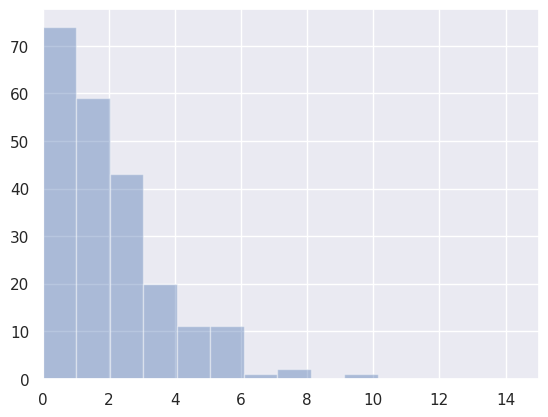

In [ ]:
# m-distance 분포를 시각화하여 flag anomaly에 대한 좋은 임계갑승ㄹ 설정해야 한다.

# m-distance의 제곱(square)을 시각화 (χ2 distribution)
plt.figure()
sns.distplot(np.square(dist_train),
             bins = 10,
             kde= False);
plt.xlim([0.0,15])

Text(0.5, 0, 'Mahalanobis dist')

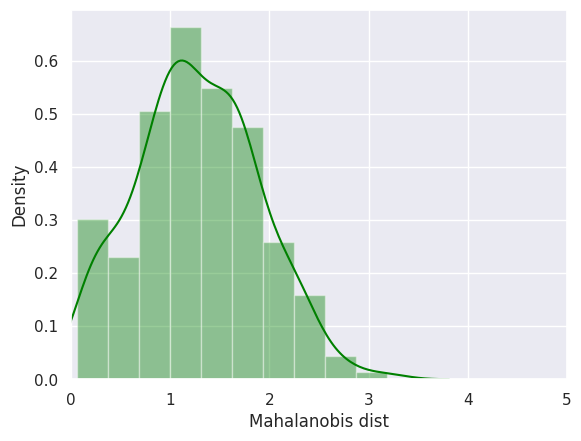

In [ ]:
# m-distance 시각화
plt.figure()
sns.distplot(dist_train,
             bins = 10,
             kde= True,
            color = 'green');
plt.xlim([0.0,5])
plt.xlabel('Mahalanobis dist')



In [ ]:
# Expected: 이 그래프에서 mahalanobis distance의 최대값은 약3.8로 나타남 => 앞서 계산한 임계값 3.8이 타당하다!
# Mine: 3.8120454918056526 is maybe too high ??
import math
threshold = math.floor(threshold)
threshold

3

In [ ]:
# save m-distance, threshold, anomaly flag to dataframe

# train
anomaly_train = pd.DataFrame()
anomaly_train['Mob dist'] = dist_train
anomaly_train['Thresh'] = threshold
# If Mob dist above threshold: Flag as anomaly
anomaly_train['Anomaly'] = anomaly_train['Mob dist'] > anomaly_train['Thresh']
anomaly_train.index = X_train_PCA.index

# test
anomaly = pd.DataFrame()
anomaly['Mob dist'] = dist_test
anomaly['Thresh'] = threshold
# If Mob dist above threshold: Flag as anomaly
anomaly['Anomaly'] = anomaly['Mob dist'] > anomaly['Thresh']
anomaly.index = X_test_PCA.index
anomaly.head()

,Mob dist,Thresh,Anomaly
2004-02-13 23:52:39,0.895470,3,False
2004-02-14 00:02:39,0.884575,3,False
2004-02-14 00:12:39,0.898058,3,False
2004-02-14 00:22:39,0.863729,3,False
2004-02-14 00:32:39,0.873659,3,False


In [ ]:
anomaly[anomaly['Mob dist'] > 3]

,Mob dist,Thresh,Anomaly
2004-02-19 04:22:39,3.072163,3,True
2004-02-19 05:02:39,3.321952,3,True
2004-02-19 05:12:39,3.011165,3,True
2004-02-19 05:22:39,3.122537,3,True
2004-02-19 05:42:39,3.994028,3,True
2004-02-19 06:02:39,3.214215,3,True
2004-02-19 06:12:39,3.409025,3,True
2004-02-19 06:22:39,3.470308,3,True


In [ ]:
# merge the data in a single dataframe
anomaly_alldata = pd.concat([anomaly_train, anomaly])
# save as a .csv file
anomaly_alldata.to_csv('Anomaly_distance.csv')

### Verifying PCA model on test data

<Axes: >

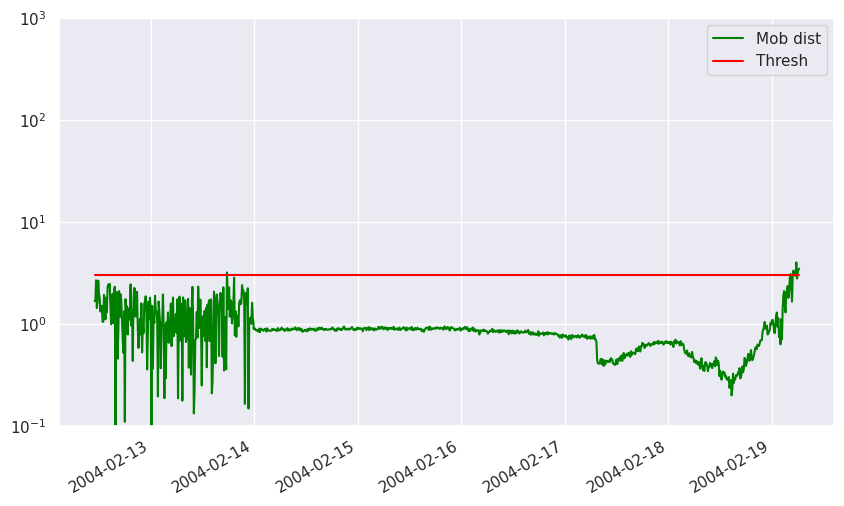

In [ ]:
# plot the calculated anomaly metric(Mob dist)
# check when it crosses the anomaly theshold

anomaly_alldata.plot(logy=True,    # logarithmic y-axis
                    figsize=(10, 6),
                    ylim = [1e-1, 1e3],
                    color = ['green', 'red'])

# Expected Result: 이 그래프에서 모델이 실제 bearing failure보다 약 3days 앞서 anomaly를 감지하는 것을 알 수 있음

**Expected Result...**

![image.png](attachment:a7a5d538-d07b-4f97-b7d9-9acc12c0c3a5.png)

## Autoencoder model for anomaly detection

- use an autoencoder neural network to “compress” the sensor readings to a low dimensional representation,
    - which captures the correlations and interactions between the various variables.

PCA model과 같은 원리이지만, 여기서는 input variables의 **non-linearities**도 허용!

**Autoencoder Network**

- 3 layer neural network
    1. 1st layer: 10 nodes
    2. Middle layer: 2 nodes
    3. 3rd layer: 10 nodes
- Loss function: MSE(mean square error)    // autoencoder에서 흔히 쓰임
- Optimizer: Adam

In [ ]:
import random

random.seed(10)
act_func = 'elu'

# Input layer:
model = Sequential()

# First hidden layer, connected to input vector X.
model.add(Dense(10, activation=act_func,
                   kernel_initializer='glorot_uniform',
                   kernel_regularizer=regularizers.l2(0.0),
                   input_shape=(X_train.shape[1],)
               )
         )

model.add(Dense(2, activation=act_func,
               kernel_initializer='glorot_uniform'))

model.add(Dense(10, activation=act_func,
               kernel_initializer='glorot_uniform'))

model.add(Dense(X_train.shape[1], kernel_initializer='glorot_uniform'))

model.compile(loss='mse', optimizer='adam')

# Train model for 100 epochs, batch size of 10:
NUM_EPOCHS=100

BATCH_SIZE=10

Fitting the model

아래 코드에서...

`np.array(X_train)` and `np.array(X_train)` are used as both the input and target data during training.

**The autoencoder is trained to reconstruct the input data, so the target data is set to be the same as the input data**.

In [ ]:
# train data의 5%를 각 epoch 이후 validation에 사용

history = model.fit(np.array(X_train), np.array(X_train),
                       batch_size=BATCH_SIZE,
                       epochs=NUM_EPOCHS,
                       validation_split=0.05,
                       verbose=1)

Epoch 1/100
21/21 [==============================] - 2s 27ms/step - loss: 0.1260 - val_loss: 0.0416
Epoch 2/100
21/21 [==============================] - 0s 3ms/step - loss: 0.0442 - val_loss: 0.0187
Epoch 3/100
21/21 [==============================] - 0s 3ms/step - loss: 0.0247 - val_loss: 0.0224
Epoch 4/100
21/21 [==============================] - 0s 3ms/step - loss: 0.0219 - val_loss: 0.0209
Epoch 5/100
21/21 [==============================] - 0s 3ms/step - loss: 0.0208 - val_loss: 0.0194
Epoch 6/100
21/21 [==============================] - 0s 4ms/step - loss: 0.0199 - val_loss: 0.0195
Epoch 7/100
21/21 [==============================] - 0s 4ms/step - loss: 0.0191 - val_loss: 0.0188
Epoch 8/100
21/21 [==============================] - 0s 3ms/step - loss: 0.0184 - val_loss: 0.0182
Epoch 9/100
21/21 [==============================] - 0s 4ms/step - loss: 0.0177 - val_loss: 0.0182
Epoch 10/100
21/21 [==============================] - 0s 5ms/step - loss: 0.0170 - val_loss: 0.0174
Epoch 11

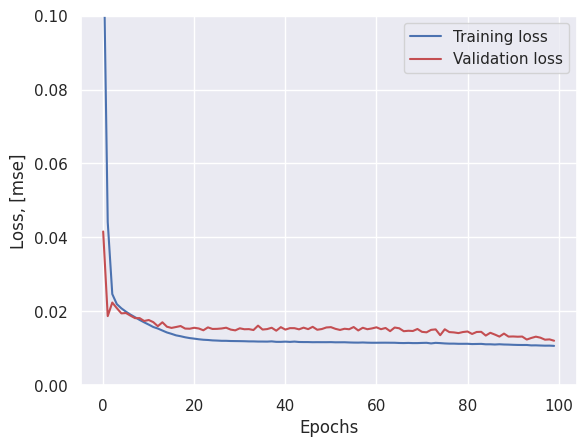

In [ ]:
# Visualize training/validation loss:
plt.plot(history.history['loss'],
         'b',
         label='Training loss')
plt.plot(history.history['val_loss'],
         'r',
         label='Validation loss')
plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Loss, [mse]')
plt.ylim([0,.1])
plt.show()

7/7 [==============================] - 0s 2ms/step


(0.0, 0.5)

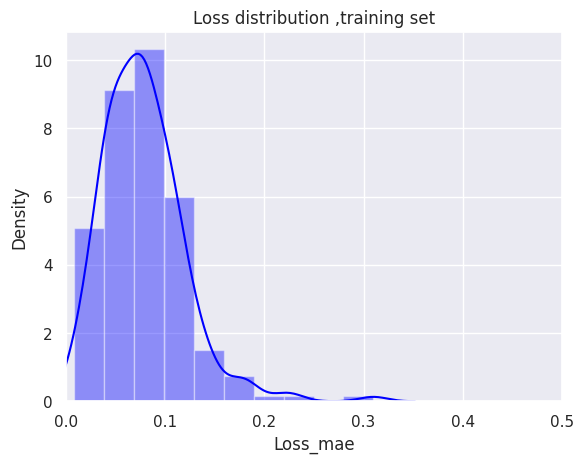

In [ ]:
# Distribution of loss function in the training set
#    -> use this to identify a suitable threshold value for identifying an anomaly

X_pred = model.predict(np.array(X_train))   # X_pred: reconstructed data, X_train: actual data
X_pred = pd.DataFrame(X_pred, columns=X_train.columns)
X_pred.index = X_train.index

scored = pd.DataFrame(index=X_train.index)
scored['Loss_mae'] = np.mean(np.abs(X_pred-X_train), axis=1)

plt.figure()
sns.distplot(scored['Loss_mae'],
            bins=10,
            kde=True,
            color='blue');
plt.title("Loss distribution ,training set")
plt.xlim([0.0, .5])  # set y-axis range

**Why MAE? by ChatGPT**

Using Mean Absolute Error (MAE) for the loss distribution has some specific advantages and considerations in the context of anomaly detection:

1. Robustness to Outliers: MAE is less sensitive to outliers compared to MSE. Outliers can significantly impact the reconstruction error in the autoencoder, and using MAE can make the loss distribution more robust in the presence of extreme values.

2. Interpretable Scale: MAE produces absolute differences between the original input and the reconstructed output. This makes the scale of the loss values more interpretable and easier to reason about in comparison to squared differences in MSE, especially if the input data has varying scales.

3. Linear Reconstruction Errors: MAE provides a linear penalty for errors. While both MAE and MSE aim to minimize reconstruction errors, the linear penalty of MAE may be preferable in some cases, as it gives equal weight to all errors regardless of their magnitude.

4. Potential Suitability for Specific Data Distributions: In certain scenarios, the data distribution or the characteristics of anomalies may align better with MAE as opposed to MSE. Anomaly patterns that cause small but consistent deviations from normal behavior may be better captured by MAE.

5. Complementary to MSE: Using both MAE and MSE can provide a more comprehensive view of the model's performance. Some anomalies may be better detected using one metric over the other, and using both metrics allows for a more balanced evaluation.

It's important to note that the choice between MAE and MSE should be based on the specific characteristics of the dataset and the anomaly detection task at hand. In practice, both MAE and MSE have been used successfully for anomaly detection with autoencoders. Experimentation and empirical evaluation on the specific dataset are essential to determine which loss function works best for your particular use case. Additionally, you may explore other loss functions tailored to anomaly detection, such as Huber loss, which combines properties of both MAE and MSE.

From the above loss distribution, try **a threshold of 0.3** for flagging an anomaly.
- Threshold를 0.3으로 해서 anomaly flagging 진행해보자

Then, we can calculate the loss in the test set to check when the output crosses the anomaly theshold.

In [ ]:
X_pred = model.predict(np.array(X_test))
X_pred = pd.DataFrame(X_pred, columns=X_test.columns)
X_pred.index = X_test.index

scored = pd.DataFrame(index=X_test.index)
scored['Loss_mae'] = np.mean(np.abs(X_pred - X_test), axis=1)
scored['Threshold'] = 0.3
scored['Anomaly'] = scored['Loss_mae'] > scored['Threshold']
scored.head()

24/24 [==============================] - 0s 2ms/step


,Loss_mae,Threshold,Anomaly
2004-02-13 23:52:39,0.103725,0.3,False
2004-02-14 00:02:39,0.104535,0.3,False
2004-02-14 00:12:39,0.104957,0.3,False
2004-02-14 00:22:39,0.105451,0.3,False
2004-02-14 00:32:39,0.104483,0.3,False


In [ ]:
# calculate the same metrics also for the training set
X_pred_train = model.predict(np.array(X_train))
X_pred_train = pd.DataFrame(X_pred_train, columns=X_train.columns)
X_pred_train.index = X_train.index

scored_train = pd.DataFrame(index=X_train.index)
scored_train['Loss_mae'] = np.mean(np.abs(X_pred_train - X_train), axis = 1)
scored_train['Threshold'] = 0.3
scored_train['Anomaly'] = scored_train['Loss_mae'] > scored_train['Threshold']

# merge all data in single dataframe
scored = pd.concat([scored_train, scored])

7/7 [==============================] - 0s 2ms/step


### Results from Autoencoder model

In [ ]:
scored.plot(logy=True,  figsize = (10,6), ylim = [1e-2,1e2], color = ['blue','red'])

**Expected results**

![image.png](attachment:3a63ed55-8022-42c0-8b5f-6db95e081d3b.png)

## Summary

Both modeling approaches give similar results.
- The main difference is how to define a suitble threshold value for flagging anomalies to avoid too many false positives during noraml operating conditions.

<br>

But it's not like what the reference article shows.
> In my case, 0.3 for threshold seems too high...



<br>

By author...

> The point about using the reconstruction error as a measure of “anomaly”, is that the autoencoder is trained to reconstruct what is referred to as the “normal” signal, as training data should only include normal operating states. Thus, when the trained autonecoder experiences an “anomaly”, it should not be able to reconstruct the input that well anymore, as the interplay/correlation among the input variables should be different from the normal conditions it has been trained on, and thus the reconstruction error could be used as a measure of “anomaly” in the input signal.